# Surface relative humidity

- Data from ERA-INTERIM.
- Trends of observed data.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import glob
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from matplotlib import dates as mdates
from dask.diagnostics import ProgressBar
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from eofs.xarray import Eof

%matplotlib inline

In [4]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [5]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/ERA_INTERIM/surface_relative_humidity_mmeans/"

In [6]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Load data

In [8]:
# List files.
FILES_MMEANS = sorted(glob.glob(DATA_FOLDER + "*.nc"))
FILES_MMEANS[:5]

['/media/alex/ALEXDATA/data_sets/ERA_INTERIM/surface_relative_humidity_mmeans/relhum_mmeans_1979.nc',
 '/media/alex/ALEXDATA/data_sets/ERA_INTERIM/surface_relative_humidity_mmeans/relhum_mmeans_1980.nc',
 '/media/alex/ALEXDATA/data_sets/ERA_INTERIM/surface_relative_humidity_mmeans/relhum_mmeans_1981.nc',
 '/media/alex/ALEXDATA/data_sets/ERA_INTERIM/surface_relative_humidity_mmeans/relhum_mmeans_1982.nc',
 '/media/alex/ALEXDATA/data_sets/ERA_INTERIM/surface_relative_humidity_mmeans/relhum_mmeans_1983.nc']

In [9]:
%%time

# DataSets objects.
DS = xr.open_mfdataset(FILES_MMEANS, concat_dim="time")
DS

CPU times: user 1.51 s, sys: 124 ms, total: 1.63 s
Wall time: 2.88 s


<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 480)
Coordinates:
    step        timedelta64[ns] 00:00:00
    number      int64 0
    surface     int64 0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
    valid_time  (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    relhum      (time, latitude, longitude) float32 dask.array<chunksize=(12, 241, 480), meta=np.ndarray>
Attributes:
    Calculation:  Made by Alex Araujo at 2019-06-16
    Origin:       ERA-INTERIM data sets for surface temperature and surface d...

In [10]:
%%time

# Shift longitudes and guarantee time ordering.
DS = DS.assign_coords(longitude=(DS.longitude + 180) % 360 - 180)
DS = DS.sortby(DS.longitude)
DS = DS.sortby(DS.time)
DS

CPU times: user 25.3 ms, sys: 3.8 ms, total: 29.1 ms
Wall time: 28.7 ms


<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 480)
Coordinates:
    step        timedelta64[ns] 00:00:00
    number      int64 0
    surface     int64 0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
    valid_time  (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    relhum      (time, latitude, longitude) float32 dask.array<chunksize=(12, 241, 480), meta=np.ndarray>
Attributes:
    Calculation:  Made by Alex Araujo at 2019-06-16
    Origin:       ERA-INTERIM data sets for surface temperature and surface d...

In [11]:
# South America.
DS = DS.sel(longitude=slice(loni, lonf), latitude=slice(lati, latf))
DS

<xarray.Dataset>
Dimensions:     (latitude: 107, longitude: 81, time: 480)
Coordinates:
    step        timedelta64[ns] 00:00:00
    number      int64 0
    surface     int64 0
  * latitude    (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * longitude   (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
    valid_time  (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
Data variables:
    relhum      (time, latitude, longitude) float32 dask.array<chunksize=(12, 107, 81), meta=np.ndarray>
Attributes:
    Calculation:  Made by Alex Araujo at 2019-06-16
    Origin:       ERA-INTERIM data sets for surface temperature and surface d...

In [12]:
DA = DS.relhum
DA

<xarray.DataArray 'relhum' (time: 480, latitude: 107, longitude: 81)>
dask.array<getitem, shape=(480, 107, 81), dtype=float32, chunksize=(12, 107, 81), chunktype=numpy.ndarray>
Coordinates:
    step        timedelta64[ns] 00:00:00
    number      int64 0
    surface     int64 0
  * latitude    (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * longitude   (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
    valid_time  (time) datetime64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    units:    %

In [13]:
# Load data into memory.
with ProgressBar():
    DA = DA.compute()

[########################################] | 100% Completed |  6.1s


## Show me the data

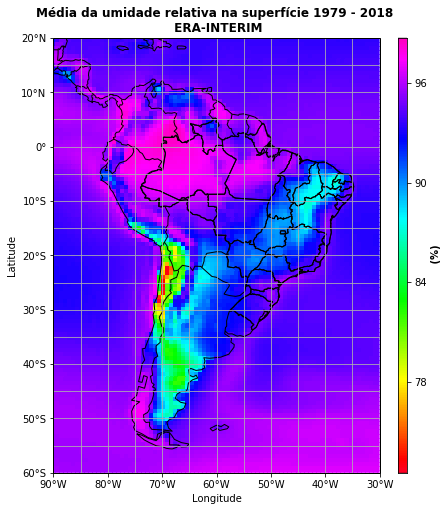

In [18]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, lati, latf], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    p = DA.mean("time").plot(
        ax=axis,
        cmap=plt.cm.gist_rainbow,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Média da umidade relativa na superfície 1979 - 2018 \n ERA-INTERIM", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text(" (%)", weight="bold")

In [19]:
# Linear trends and its statistics.
trends, _ = cdlearn.statistics.linear_trends(DA)
linstats = cdlearn.statistics.linear_regression(DA)

# Land mask at ERA-INTERIM grid.
linstats = cdlearn.pixels.EraInterimGrid.add_land_mask(linstats)

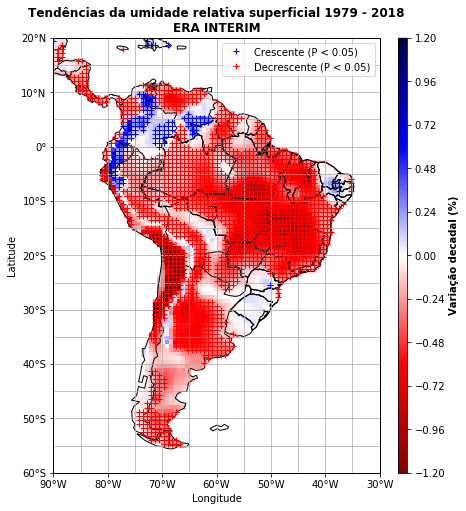

In [34]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    factor = 120
    da = (linstats.sel(stats="slope") * factor).where(linstats.land_mask==True)
    p = da.plot(
        ax=axis,
        vmin=-1.0e-2 * factor,
        vmax=1.0e-2 * factor,
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Tendências da umidade relativa superficial 1979 - 2018\n" + \
                     "ERA INTERIM", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Variação decadal (%)", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0e-2 * factor, (1.0e-2 + 0.2e-2) * factor, 0.2e-2 * factor))

# Statistical significant trends.
mask = linstats.sel(stats="p_value") < 0.05
mask_up = linstats.sel(stats="slope") > 0
mask_down = linstats.sel(stats="slope") < 0
LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

# Incresing!
msk = np.logical_and(mask, mask_up)
msk = msk.where(msk.land_mask == True, False)
axis.plot(LON[msk], LAT[msk], "+b", label="Crescente (P < 0.05)", transform=projection)
    
# Decreasing!
msk = np.logical_and(mask, mask_down)
msk = msk.where(msk.land_mask == True, False)
axis.plot(LON[msk], LAT[msk], "+r", label="Decrescente (P < 0.05)", transform=projection)    

# Legend.    
axis.legend() 
    
# Save figure.
plt.savefig(fig_path + "surface_relative_humidity_erainterim_trends_pt.jpg", 
            dpi=200, bbox_inches="tight")